# Proyecto 1 Inteligencia de Negocios

## Miembros
Diego Granada Martínez - 201922383
Andres Felipe Arias Russi - 201914996
Verónica Escobar Aristizabal - 201922197

## Contexto del Proyecto - Salud Mental

Se decidio trabajar bajo el contexto de salud mental, y se desarollara el proyecto alrededor del apooyo a la detección de intentos de suicidio a partir de información de Reddit a nivel de comunidades que sufren de depresión o han intentado suicidarse.

## Información sobre el data set a usar

Como ya se menciono la información es recolectada de la red social de Reddit. El set de datos es una coleccion de posts realizados a las comunidades de r/SuicideWatch y r/Depression. El autor del dataset menciona que los datos fueron recolectados por medio de PutshiftAPI. Los datos de SuicideWatch toma un recuento de todos los posts hechos a esa comunidad desde diciembre de 2008 a enero de 2021, mientras que los datos de r/Depression fueron recolectados desde las fechas de Enero de 2009 a Enero de 2021. Por lo tanto, ambos datasets recolectan aproximadamente 12 años de posts en total de cada una de las comunidades. Aunque este es el set de datos original para la investigacion el set de datos base que se va a usar en el proyecto es el proporcionado por el equipo de Inteligencia de Negocios en un ZIP que contiene dos archivos uno el cual contiene un set de datos sin clasificar si son suicidal o non-suicidal mientras que otro ya tiene las clasificaciones hechas.

## Estructura del Proyecto

El proyecto se divide en dos etapas. La primera etapa esta relacioanda a la construccion de modelos de datos analiticos, y el rol principal del equipo es el de cientificos de datos. La segunda etapa esta relacionada a el despliegue de estos modelos analiticos y el desarollo de una aplicacion, aqui el rol principal es el de un ingeniero de datos.


# Etapa 1

## Proceso de perfilamiento y entendimiento de los datos 



### Carga de datos y configuración



In [9]:
SHOW_PROFILE = False # REVISAR ANTES DE ENTREGAR
RAM_DANGER = True #Correr estos en maquina aparte
!pip install -r requirements.txt

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [10]:
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error, plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, KFold 
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import tree
import pickle
from pandas_profiling import ProfileReport
import nltk
import html
from collections import  Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import gensim
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from sklearn.feature_extraction import text 
import yellowbrick
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
#creaDataFrame
train_original_data = pd.read_csv('SuicidiosProyecto.csv', sep=',', encoding = 'utf-8', index_col=0)
test_original_data = pd.read_csv('SuicidiosProyectoSinEtiqueta.csv', sep=',', encoding = 'utf-8', index_col=0)
train_original_data.head(10)


,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,I kinda got behind schedule with learning for ...,non-suicide
256637,I'm just not sure anymoreFirst and foremost: I...,suicide
303772,please give me a reason to liveThats too much ...,suicide
293747,27f struggling to find meaning moving forwardI...,suicide
205651,Let’s get this bread 😎 Anyone know any good ba...,non-suicide
97174,"Day 126 of posting random ""fun"" facts everyday...",non-suicide
195945,Little brother is self mutilating. Please help...,suicide
305273,Why do women always go in groups to their wash...,non-suicide


In [4]:
train_original_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195700 entries, 173271 to 305170
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    195700 non-null  object
 1   class   195700 non-null  object
dtypes: object(2)
memory usage: 4.5+ MB


In [5]:
train_original_data.describe(include='all')

,text,class
count,195700,195700
unique,195700,2
top,I made somebody upset by posting about him Ya ...,non-suicide
freq,1,110165


### Observaciones Iniciales

Revisando los datos superficialmente uno de los primeros problemas que notamos son algunos problemas de codificacion de los datos dados. En este caso sospechamos que cuando se estaba creando el set de datos se descargo con la codificacion de windows pero cuando se creo y subio el excel se uso la codificacion de utf-8 por lo tanto algunos caracteres quedaron irreconocibles debido a este cambio. Durante el procesamiento de datos tendremos que tratar con estas irregularidades antes de poder crear el bag de palabras para proceder con el analisis de los datos. Esto va a requerir ver como se puede volver a recrear el encoding original de tal forma que podamos recuperar los caracteres originales.

## Importar datos Originales

In [12]:
train_data = train_original_data.copy()
test_data = test_original_data.copy()

## Entendimiento de datos y visualizacion preliminar

Para la primera etapa se hara una visualizacion preliminar de los datos de tal forma que se puedan entender mejor los datos y reconocer problemas con la calidad de datos antes de comenzar a hacer la limpieza y procesamiento de estos.

En la primera seccion de Entendimiento de datos agregados se va juntar tanto el set de datos de entrenamiento como los de prueba en la columna de text ya que el proposito de la visualizacion es poder entender los datos en general y reconocer algunos problemas de calidad generalizados tanto en el set de datos de entrenamiento como en el de prueba. Con los problemas de calidad generalizados se va a poder establecer algunos lineamientos sobre que tipo de limpieza y pre procesamiento se tendran que hacer sobre los datos.

### Entendimiento de datos agregados

En esta seccion se van a agregar tanto el set de datos de entrenamiento como el set de datos de prueba y se van a explorar que caracteristicas tienen en general.

In [13]:
#Uniendo set de datos de prueba y set de datos de entrenamiento sobre la columna text
pre_vis_1 = train_data[['text']].copy()
pre_vis_2 = test_data[['text']].copy()
pre_vis = pd.concat([pre_vis_1, pre_vis_2])

Aqui se puede visualizar un set de ejemplo de los datos que se estan manejando. Se puede ver que tanto se tiene una variedad de datos de discusiones no relacionadas a la salud mental, probablemente vienen de otras comunidades de Reddit no, asi como datos mas relacionados a la tematica de ideacion suicida o discusiones sobre salud mental. Otro elemento interesante que se puede resaltar es el uso de palabras o lingo relacionado al internet que en un contexto tradicional podria cobrar un sentido mas literal pero en el contexto de los posts puede significar algo diferente, esto puede presentar un reto a la hora de procesar los datos y construir un modelo ya que reconocer este tipo de palabras puede ser dificil por que dependen mucho del contexto en el que son usadas. Otro elemento interesante es la presencia de emojis o otros simbolos que tenemos que tener en cuenta a la hora de procesar los datos.

In [8]:
#Visualizando datos
pre_vis.head(10)

,text
Unnamed: 0,
173271,i want to destroy myselffor once everything wa...
336321,I kinda got behind schedule with learning for ...
256637,I'm just not sure anymoreFirst and foremost: I...
303772,please give me a reason to liveThats too much ...
293747,27f struggling to find meaning moving forwardI...
205651,Let’s get this bread 😎 Anyone know any good ba...
97174,"Day 126 of posting random ""fun"" facts everyday..."
195945,Little brother is self mutilating. Please help...
305273,Why do women always go in groups to their wash...


In [14]:
#Descarga de librerias de nltk utiles para el analisis
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

A continuacion se va a hacer un diagrama que muestra las stop words mas frecuentes en los datos. A la hora de procesar los datos es ideal que estas palabras se remuevan este tipo de palabras ya que usualmente no añaden informacion adicional sobre el sentimiento de los datos en si, son relleno en forma de conectores o otros tipos de palabras. 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


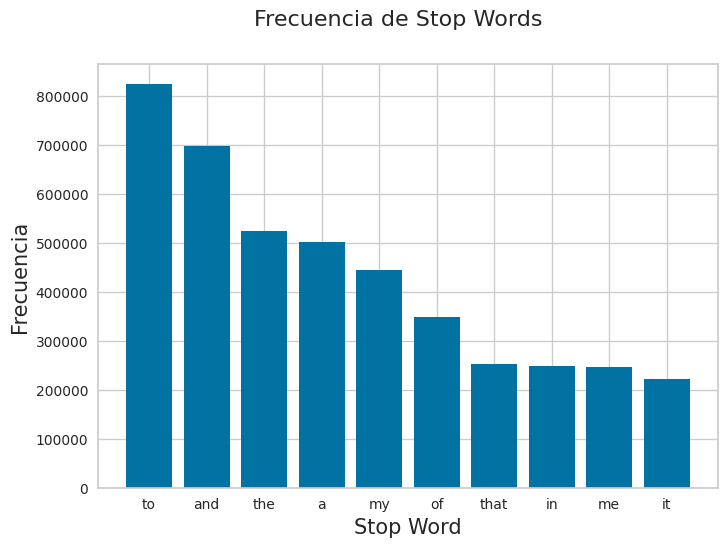

In [16]:
#Plot las stop words mas frecuentes en los datos
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    corpus=[]
    wrds = pre_vis['text'].str.split()
    wrds = wrds.values.tolist()
    corpus=[word for i in wrds for word in i]

    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)

    fig = plt.figure()
    fig.suptitle('Frecuencia de Stop Words', fontsize=16)
    plt.xlabel('Stop Word', fontsize=15)
    plt.ylabel('Frecuencia', fontsize=15)
    fig.savefig('StopWordFrequency.jpg')
    plt.bar(x,y)
    plt.show()


plot_top_stopwords_barchart(pre_vis['text'])

A continuacion se presenta un analisis de frecuencia de las palabras mas comunes, no stop words, presentes en los datos. 

En esta lista se puede ver algunas palabras relevantes en el contexto de discusiones de salud mental e ideacion suicida estan presentes en el set de datos y lo relevantes que son. En este caso se ve una gran frecuencia de palabras con conotaciones claramente negativas como :  fuck, fucking, die , etc. Sin embargo, la mayoria de las palabras directametne no tienen una conotacion negativa. Una gran cantidad de palabras son posesivas o presuntamente hacen referencia a la persona que esta escrbiendo y que conociendo el contexto del set de datos pueden tener una cualidad mas introspectiva o reflexiva y  se relacionan a cosas que nesecitan, quieren, sienten, conocen , piensan, aman, etc.  Adicionalmente hay una alta frecuencia de menciones de amigos, familia o personas que los rodean las cuales tienen sentido dentro del contexto de discusiones de salud mental.

Una observacion importante para el procesamiento de datos es la frecuencia del uso de abreviaciones (contractions en ingles) que son el uso de un apostrofe (') en una palabra (ej: don't = do not) para unir y abreviar dos palabras de mayor largo. Aqui es evidente que en el procesamiento de datos estas apostrofes no se reconocen y se rompen como dos palabras diferentes. Se tendra que asegurar de romper o mas bien expandir estas abreviaciones para asi entender el sentido completo de lo que se esta diciendo y posiblemente remover mas stop words para facilitar el analisis de sentimiento. En el set de datos se ve el efecto de no hacer esto, tal como las palabras 'don' ( presuntamente viniendo de la palabra "don't") , 've' (probablemente viene de "I've" que abrevia I have). 

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/root/venv/lib/python3.9/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none o

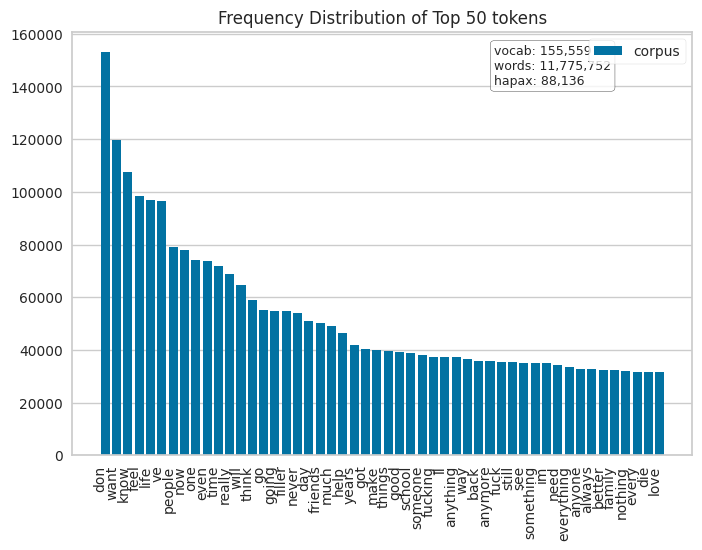

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [11]:
#Plot las palabras (no stopwords) mas frecuentes en los datos
stopwordsA = set(STOPWORDS)
vectorizer = CountVectorizer(stop_words=stopwordsA)
docs = vectorizer.fit_transform(pre_vis['text'])
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.poof()

La siguiente imagen presenta el diagrama de frecuencia anterior de una forma mas amigable, en la forma de un word cloud, asi dejando ver de forma mas clara el tipo de palabras que estan siendo usadas en general. Con esta word cloud se hacen mas evidentes palabras con conotaciones mas negativas, especialmente en el contexto de la salud mental, asi como son 'kill', 'shit', 'hate', 'pain', 'tired', 'alone', 'hurt', 'lost', 'depression' entre otras. 

Una observacion importante que se puede sacar de  este word cloud es que se vuelve mas relevante la importancia de los tiempos de los verbos usados. Un ejemplo de esto es la presencia de living, lived, live los cuales se pueden reducir a la raiz de live. En el procesamiento de datos se tiene que encontrar una forma de reducir este tipo de palabras a su raiz. Adicionalmente, la presencia de sufijos en ciertas palabras resalta la nesecidad de encontrar la palabra raiz de estos datos (ej: slow es la raiz de slowly).

  box_size = draw.textsize(word, font=transposed_font)
/root/venv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/root/venv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/root/venv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/root/venv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_si

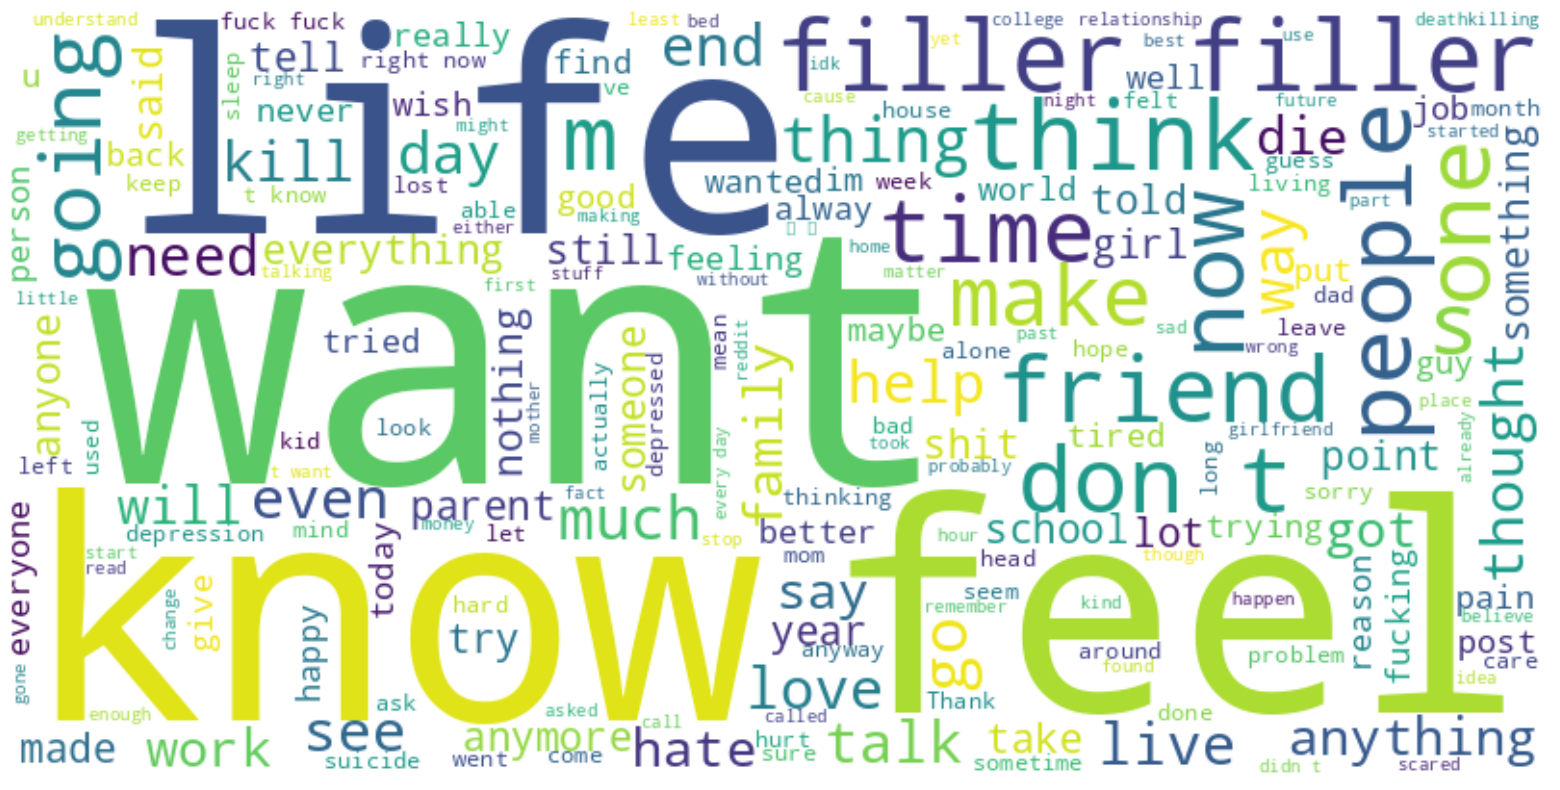

In [12]:
#Word cloud
text = " ".join(i for i in pre_vis.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800, height=400,stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Tomando en cuenta el analisis anterior de palabras individuales donde la frecuencia relativa de palabras con cualidades mas evidentemente negativas no es tan alta en comparacion a otras palabras cuyo sentido es mas ambiguo si se sacan fuera de contexto. Por lo tanto, analizar que tipos de palabras son usadas mas en conjunto puede traer mas sentido a las palabras y lo que nos indican.

In [13]:
#Define una funcion que hace un plot de las colecciones de n palabras contiguas que mas apariciones hacen en los datos. 
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

Para un n-grama de dos palabras, bi-grama , la mayoria de palabras son posesivas y se refieren a una accion que se queiere hacer. SIn embargo, se nesecita mas contexto para darle sentido a estas palabras.

In [14]:
if not RAM_DANGER:
    plot_top_ngrams_barchart(pre_vis['text'],2)

<img src='ngram2.png' width="600" height="600">

Con un n-grama de 3 palabras , tri-grama, se puede ver un poco mas de significado en las oraciones. En este n-grama si se pudo obtener mucha mas informacion sobre los sentimientos mas frecuentes, y en su mayoria son negativos. Es sorprendente la cantidad de palabras repetidas como filler que aparecen , pero tras investigar un poco más en las paginas de origen de los datos se pudo determinar que el sentido de la palabra en este contexto esta relacionada en sentirse como 'filler' o relleno en la vida de otros o la de uno mismo, por lo tanto no se puede tomar como un 'red-herring' en esta situacion y es una palabra que esta negativamente correlacionada a la salud mental de la persona que realizo el post. 

In [15]:
if not RAM_DANGER:
    plot_top_ngrams_barchart(pre_vis['text'],3)

<img src='ngram3.png' width="600" height="600">

En el n-grama de 4 palabras no se pudo obtener una gran cantidad mas de informacion relevante. Varios de los datos encontrados son palabras repetidas como cheese, it , ur mom, entre otras. Ur mom es normalmente usado como un insulto por lo tanto valdria la pena revisar los sets de datos que lo mencionan ya que podrian ser señuelos, lo mismo aplica con cheese, sus e it. Unicamente sus y ur mom tienen algun significado en el contexto del internet, mientras que palabras como it y cheese no tienen ningun contexto dentro de las discusiones de salud mental como lo tenia filler.

In [16]:
if not RAM_DANGER:
    plot_top_ngrams_barchart(pre_vis['text'],4)

<img src='ngram4.png' width="600" height="600">

En los N-gramas de 5 y 6 palabras no se pudo obtener mucha informacion adicional sobre el contexto de los datos. Sin embargo, es muy evidente que en el procesamiento de dato se tendra que buscar alguna forma de reducir estas palabras para que asi no ocupen tanto espacio, ya que de igual forma su significado (o falta de este) no depende de su repeticion.

In [17]:
if not RAM_DANGER:
    plot_top_ngrams_barchart(pre_vis['text'],5)

<img src='ngram5.png' width="600" height="600">

In [18]:
if not RAM_DANGER:
    plot_top_ngrams_barchart(pre_vis['text'],6)

<img src='ngram6.png' width="600" height="600">

#### Conclusiones de entendimiento de datos
El entendimiento de datos ayudo a entender mas el tipo de informacion con el que se esta manejando y a resaltar algunas palabras claves o elementos que observar a la hora de procesar los datos. En terminos de calidad no se evaluaron muchos factores, pero estos seran tratados de igual forma en la siguiente seccion (Procesamiento). Muchos aspectos de entender las palabras y lidiar con caracteristicas de la gramatia en ingles (contracciones, tiempos, etc), conectores y stopwords y ciertas palabras que aparecen frecuentemente en el contexto del internet (tal como repeticion para enfatizar un punto) se pudieron analizar. Adicionalmente, se pudo entender el tipo de palabras que rodean las discusiones de salud mental y que pueden servir como alerta para el modelo que se desarolle posteriormente.

### Procesamiento y limpieza

Primero se trataran con los problemas reconocidos en el entendimiento de los datos y despues se tratara con los factores de calidad.

##### Arreglando codificacion de los datos
Como se menciono al inicio uno de los problemas iniciales de los datos fue manejar su codificacion aqui esta el procesamiento para arreglar estos problemas y retornar los textos a su estado original sin nesecidad de remover palabras sin nesecidad.

In [19]:
import html
def procesar_texto(cell):
    try:
        #print(cell)
        processed_text = str(html.unescape(cell))
        #processed_text = processed_text.encode("cp1252")
        #processed_text = processed_text.decode('utf-8')
    except Exception as E:
        #print(processed_text)
        raise E
    return processed_text

train_data['text'] = train_data['text'].map(procesar_texto)
test_data['text'] = test_data['text'].map(procesar_texto)
train_data


,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,I kinda got behind schedule with learning for ...,non-suicide
256637,I'm just not sure anymoreFirst and foremost: I...,suicide
303772,please give me a reason to liveThats too much ...,suicide
293747,27f struggling to find meaning moving forwardI...,suicide
...,...,...
248038,Drop some cool new cereal ideas Like what woul...,non-suicide
216516,Unpopular opinion but cats deserve love and re...,non-suicide
199341,Hey guys :) How yall doin?,non-suicide


##### Expandir contracciones, lowercase, new lines y remover puntuacion

Se van a remover contracciones, se va a pasar todos los textos a minuscula se van a remover los new lines y se va a remover la pountuacion para hacer mas facil el procesamiento de los datos.

In [20]:
#Expandir contracciones, lowercase , new lines y remover puntuacion

import string

def cleanContLowNlP(cell):
    try:
        currData = cell.lower()
        currData = currData.replace('\n','')
        currData = currData.translate(str.maketrans(' ', ' ', string.punctuation))
        
        expanded_words = []  
        for word in currData.split():
            expanded_words.append(contractions.fix(word))

        expanded_text = ' '.join(expanded_words)
        new = expanded_text
    except Exception as E:
        raise E
    return new

train_data['text'] = train_data['text'].map(cleanContLowNlP)
test_data['text'] = test_data['text'].map(cleanContLowNlP)

In [21]:
train_data

,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,i kind of got behind schedule with learning fo...,non-suicide
256637,i am just not sure anymorefirst and foremost i...,suicide
303772,please give me a reason to livethats too much ...,suicide
293747,27f struggling to find meaning moving forwardi...,suicide
...,...,...
248038,drop some cool new cereal ideas like what woul...,non-suicide
216516,unpopular opinion but cats deserve love and re...,non-suicide
199341,hey guys how you all doin,non-suicide


##### Lowercase y expandir contracciones

Para procesar los datos se van a convertir todas las palabras a lowercase para facilitar el analisis y se van a remover todas las contratcciones.

Sin embargo, como fue resaltado en la exploracion de los datos es frecuente que un texto tenga palabras repetidas para el proposito de enfatizar, entonces se va a proceder a remover estas repeticiones para concisar mas los textos en lo posible. El proceso para remover esto de todos los datos consume bastante tiempo, y memoria por lo tanto se va a primar remplazar las palabras repetidas por solo una instancia de la palabra.

In [22]:
def freqRepeatedWords(title):

    cum_freq = 0
    cheese_freq = 0
    ni_freq = 0 
    gtpopit_freq = 0
    urmom_freq = 0
    fuck_freq = 0
    filler_freq = 0
    it_freq = 0
    sus_freq = 0

    for data in train_data['text']:
        str_list = data.split()
        cum_freq += str_list.count('cum')
        cheese_freq += str_list.count('cheese')
        ni_freq += str_list.count('ni')
        gtpopit_freq += str_list.count('gt pop it')
        urmom_freq += str_list.count('ur mom')
        fuck_freq += str_list.count('fuck')
        filler_freq += str_list.count('filler')
        it_freq += str_list.count('it')
        sus_freq += str_list.count('sus')

    print(title)
    print("%s freq is %d" % ('cum',cum_freq))
    print("%s freq is %d" % ('cheese',cheese_freq))
    print("%s freq is %d" % ('ni',ni_freq))
    print("%s freq is %d" % ('gt pop it',gtpopit_freq))
    print("%s freq is %d" % ('ur mom',urmom_freq))
    print("%s freq is %d" % ('fuck',fuck_freq))
    print("%s freq is %d" % ('filler',filler_freq))
    print("%s freq is %d" % ('it',it_freq))
    print("%s freq is %d" % ('sus',sus_freq))
    print('-----------------------------------------')


In [23]:
freqRepeatedWords('Before')

Before
cum freq is 4061
cheese freq is 6205
ni freq is 4039
gt pop it freq is 0
ur mom freq is 0
fuck freq is 31016
filler freq is 51407
it freq is 329491
sus freq is 6030
-----------------------------------------


In [24]:
import itertools
def removeRepeated(cell):
    try:
        #words = cell.split()
        #answer = [each_pair[0] for each_pair in zip(words, words[1:]) if each_pair[0] != each_pair[1]] + [words[-1]]
        new = ' '.join(k for k, _ in itertools.groupby(cell.split()))
    except Exception as E:
        raise E
    return new

train_data['text'] = train_data['text'].map(removeRepeated)
test_data['text'] = test_data['text'].map(removeRepeated)




In [25]:
freqRepeatedWords('After')

After
cum freq is 603
cheese freq is 493
ni freq is 58
gt pop it freq is 0
ur mom freq is 0
fuck freq is 18694
filler freq is 4042
it freq is 319361
sus freq is 344
-----------------------------------------


In [26]:
train_data.head(10)

,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,i kind of got behind schedule with learning fo...,non-suicide
256637,i am just not sure anymorefirst and foremost i...,suicide
303772,please give me a reason to livethats too much ...,suicide
293747,27f struggling to find meaning moving forwardi...,suicide
205651,let us get this bread 😎 anyone know any good b...,non-suicide
97174,day 126 of posting random fun facts everyday u...,non-suicide
195945,little brother is self mutilating please help ...,suicide
305273,why do women always go in groups to their wash...,non-suicide


##### Remover stopwords y numeros

A continuacion se van a remover todos los valores numericos y stop words de las palabras.

In [27]:
from gensim.parsing.preprocessing import remove_stopwords

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    try:
        text_nonum = re.sub(r'\d+', '', words)
    except Exception as E:
        raise E
    return text_nonum

def remove_stopwords(cell):
    """Remove stop words from list of tokenized words"""
    try:
        filtered_list = []
        stop_words = nltk.corpus.stopwords.words('english')
        # Tokenize the sentence
        words = word_tokenize(cell)
        for w in words:
            if w.lower() not in stop_words:
                filtered_list.append(w)
    except Exception as E:
        raise E
    return ' '.join(filtered_list)


In [28]:
train_data['text'] = train_data['text'].map(remove_stopwords)
test_data['text'] = test_data['text'].map(remove_stopwords)


train_data.head(10)

,text,class
Unnamed: 0,,
173271,want destroy myselffor everything starting fee...,suicide
336321,kind got behind schedule learning next week te...,non-suicide
256637,sure anymorefirst foremost brazil judge second...,suicide
303772,please give reason livethats much reason live ...,suicide
293747,27f struggling find meaning moving forwardi ad...,suicide
205651,let us get bread 😎 anyone know good bakery sto...,non-suicide
97174,day 126 posting random fun facts everyday forg...,non-suicide
195945,little brother self mutilating please help mem...,suicide
305273,women always go groups washrooms hey guys watc...,non-suicide


In [29]:
import re

train_data['text'] = train_data['text'].map(replace_numbers)
test_data['text'] = test_data['text'].map(replace_numbers)

In [30]:
train_data.head(10)

,text,class
Unnamed: 0,,
173271,want destroy myselffor everything starting fee...,suicide
336321,kind got behind schedule learning next week te...,non-suicide
256637,sure anymorefirst foremost brazil judge second...,suicide
303772,please give reason livethats much reason live ...,suicide
293747,f struggling find meaning moving forwardi admi...,suicide
205651,let us get bread 😎 anyone know good bakery sto...,non-suicide
97174,day posting random fun facts everyday forget ...,non-suicide
195945,little brother self mutilating please help mem...,suicide
305273,women always go groups washrooms hey guys watc...,non-suicide


#### Analisis de calidad de datos
En este analisis de los datos se pueden evaluar si existen problemas en varios de los factores de calidad de datos. Para cada uno de los cuatro rubros (Completitud, Unicidad, Consistencia y Validez) se dara un pequeño analisis de resumen que va a influenciar posteriormente como se procesen los datos. Si un problema con los datos se descubre sera tratado inmediatamente.

##### Completitud
Ni en el set de datos de entrenamiento ni en el set de datos de prueba se encontraron campos con datos nulos.

In [31]:

train_data.isna().sum()


text     0
class    0
dtype: int64

In [32]:
test_data.isna().sum()

text    0
dtype: int64


##### Unicidad
No se hicieron visibles ningunos datos duplicados en ninguno de los dos set de datos.



In [33]:
train_data.duplicated().sum()

392

In [34]:
test_data.duplicated().sum()

1

##### Consistencia

No se encontro ninguna inconsistencia en la columna de clase. Para la columna de texto es muy dificil determinar inconsistencias puesto en teoria cualquier valor es valido mientras que sea de tipo texto.

In [35]:
#Frecuencia elementos en columna de clase
print('')
print('Frequency for column class')
print(train_data['class'].value_counts())


Frequency for column class
non-suicide    110165
suicide         85535
Name: class, dtype: int64


##### Validez
En terminos de validez los datos de tipo clase son todos validos y dentro de los valores esperados, en terminos de los valores de texto no se puede determinar validez por la naturaleza de los datos.


##### Encoding de etiquetas de clase
Se procesó el texto para descifrar los HTML character entities, arreglando caracteres como "&".

Ahora haremos un mapeo en los datos de entrenamiento para cambiar la etiqueta a un 0 o 1, siendo 1 las filas que corresponden a "suicide".

In [36]:
train_data['class'] = train_data['class'].map({"suicide": "1", "non-suicide": "0"})
train_data

,text,class
Unnamed: 0,,
173271,want destroy myselffor everything starting fee...,1
336321,kind got behind schedule learning next week te...,0
256637,sure anymorefirst foremost brazil judge second...,1
303772,please give reason livethats much reason live ...,1
293747,f struggling find meaning moving forwardi admi...,1
...,...,...
248038,drop cool new cereal ideas like would ideal ce...,0
216516,unpopular opinion cats deserve love respect mu...,0
199341,hey guys doin,0


##### Conclusiones Limpieza de Datos

Con los datos en este formato va a ser mas facil hacer el proceso de procesamiento posteriormente. Ahora como estan los datos estan mas estandarizados y son mas uniformes en su presentacion.


### Procesamiento de Datos
 A continuacion se hara el procesamiento para prepara los datos para aplicar el modelo. Esto implica hacer tokenizacion, normalizacion entre otros pasos.

In [37]:
train_data.head()

,text,class
Unnamed: 0,,
173271,want destroy myselffor everything starting fee...,1
336321,kind got behind schedule learning next week te...,0
256637,sure anymorefirst foremost brazil judge second...,1
303772,please give reason livethats much reason live ...,1
293747,f struggling find meaning moving forwardi admi...,1


##### Tokenizacion

In [38]:
from nltk import word_tokenize, sent_tokenize

def tokWord(cell):
    try:
        new = nltk.word_tokenize(cell)
    except Exception as E:
        raise E
    return new

train_data['words']= train_data['text'].map(tokWord)
#train_data['words'] = train_data['text'].apply(word_tokenize) #Aplica la eliminación del ruido


In [39]:
train_data.head()

,text,class,words
Unnamed: 0,,,
173271,want destroy myselffor everything starting fee...,1,"[want, destroy, myselffor, everything, startin..."
336321,kind got behind schedule learning next week te...,0,"[kind, got, behind, schedule, learning, next, ..."
256637,sure anymorefirst foremost brazil judge second...,1,"[sure, anymorefirst, foremost, brazil, judge, ..."
303772,please give reason livethats much reason live ...,1,"[please, give, reason, livethats, much, reason..."
293747,f struggling find meaning moving forwardi admi...,1,"[f, struggling, find, meaning, moving, forward..."


##### Stemming

In [40]:
from nltk.stem import PorterStemmer

def stem(cell):
    try:
        ps = PorterStemmer()
        li = []
        for word in cell:
            li.append(ps.stem(word))
    except Exception as E:
        raise E
    return li

train_data['words']= train_data['words'].map(stem)

In [41]:
train_data

,text,class,words
Unnamed: 0,,,
173271,want destroy myselffor everything starting fee...,1,"[want, destroy, myselffor, everyth, start, fee..."
336321,kind got behind schedule learning next week te...,0,"[kind, got, behind, schedul, learn, next, week..."
256637,sure anymorefirst foremost brazil judge second...,1,"[sure, anymorefirst, foremost, brazil, judg, s..."
303772,please give reason livethats much reason live ...,1,"[pleas, give, reason, livethat, much, reason, ..."
293747,f struggling find meaning moving forwardi admi...,1,"[f, struggl, find, mean, move, forwardi, admit..."
...,...,...,...
248038,drop cool new cereal ideas like would ideal ce...,0,"[drop, cool, new, cereal, idea, like, would, i..."
216516,unpopular opinion cats deserve love respect mu...,0,"[unpopular, opinion, cat, deserv, love, respec..."
199341,hey guys doin,0,"[hey, guy, doin]"


----ESTO LO HIZO DIEGO------------

In [42]:
print(train_data.columns)

Index(['text', 'class', 'words'], dtype='object')


In [43]:
### Preparacion de datos

Se definirá un pipeline para procesar los datos a una forma utilizable por los modelos

El pipeline consistirá de las siguientes partes:
1. CountVectorizer(), el cual nos dará una "bag of words", un conjunto de vectores de palabras de n con rango \[1, 2], junto con un contado de la cantidad de veces que ocurre la combinación de palabras.
2. TfidTransformer(), el cual cambia las ocurrencias a una medida de frecuencia, para evitar parcializar el modelo según el tamaño del texto de entrada, y al mismo tiempo reduciendo el peso de palabras comunes como "the", "is, "an", etc.
3. None, un transformador nulo que es necesario para poder usar la funcion pipeline.transform()

In [44]:
text_transform_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2), stop_words=stopwords.words('english'))),
    ('tfidf', TfidfTransformer()),
    None
])



AttributeError: 'set' object has no attribute 'words'

In [ ]:
transformed_train_data = text_transform_pipeline.transform(train_data['text'])